In [1]:
# library imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as plt
import seaborn as sns
import requests
import os
import tweepy
import json
from twitter_api import api # imports tweepy api with keys
from pprint import pprint
from shutil import move
from datetime import datetime, time
from collections import defaultdict

# Table of Contents
<a id='table_of_contents'></a>
* [Gather](#gather)
* [Assess](#assess)
    + [`tweet_archive_df`](#assess-tweet_archive_df)
    + [`image_predictions_df`](#assess-image_predictions_df)
    + [`tweet_json_df`](#assess-tweet_json_df)
    + [Issues](#assess-issues)
* [Clean](#clean)
    + [`tweet_archive_df`](#clean-tweet_archive_df)
    + [`image_predictions_df`](#clean-image_predictions_df)
    + [`tweet_json_df`](#clean-tweet_json_df)
* [Merge](#merge)
* [Store](#store)
* [Analyze and Visualize](#analysis)
    + [Tweet counts by month](#tweet_counts_by_month)
    + [Tweet counts by hour of day](#tweet_counts_by_hour)
    + [Dog ratings over time](#dog_ratings_over_time)
    + [Average dog breed popularity](#dog_breed_ratings)
    + [Dog stage ratings](#dog_stage_ratings)

<a id='gather'></a>
# Gather

* Create and/or set directory for data files to be stored

In [2]:
# Make directory if it doesn't already exist
folder_name = 'project_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

* Check for enhanced twitter archive file (provided): `twitter-archive-enhanced.csv`
    + If doesn't exist, this file needs to be downloaded from Udacity
    + Load data into Pandas DataFrame: `tweet_archive_df` 

In [3]:
# Check for twitter_archive_enhanced.csv
tweet_archive_file_name = 'twitter-archive-enhanced.csv'
tweet_archive_file_path = os.path.join(folder_name, tweet_archive_file_name)
# if file is in the same directory as project file,
# move it to 'project_data' folder
if os.path.isfile(tweet_archive_file_name):
    move(tweet_archive_file_name, tweet_archive_file_path)
    print("'{}' moved to '{}'.".format(tweet_archive_file_name, tweet_archive_file_path))
assert os.path.isfile(tweet_archive_file_path), \
    "Download 'twitter-archive-enhanced.csv' to '{}'.".format(tweet_archive_file_path)
# Load into DataFrame
tweet_archive_df = pd.read_csv(tweet_archive_file_path)

* Check for image prediction data file: `image-predictions.tsv`
    + If it doesn't exist, download programatically from URL 
    + Load data into Pandas DataFrame: `image_predictions_df`

In [4]:
# Check for image-predictions.tsv
# if image-predictions.tsv doesn't exist, download programatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
predictions_file_path = os.path.join(folder_name, url.split('/')[-1])
if not os.path.isfile(predictions_file_path):
    with open(predictions_file_path, mode = 'wb') as file:
        file.write(requests.get(url).content)
# Load into DataFrame
image_predictions_df = pd.read_csv(predictions_file_path, '\t')

* Check for twitter json file: `tweet_json.txt`
    + If doesn't exist, download Tweet json data using Tweepy library
    + Load data into Pandas DataFrame: `tweet_json_df`

In [5]:
text_file_name = 'tweet_json.txt'
text_file_path = os.path.join(folder_name, text_file_name)

def write_tweets(tweepy_statuses, file_path):
    """ Append tweepy Status objects as JSON string to provided file_path """
    with open(text_file_path, 'a+') as file:
        for tweepy_status in tweepy_statuses:
            file.write(json.dumps(tweepy_status._json)+'\n')
            
# list to sublist generator from:
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def create_tweet_json_file(tweet_ids, file_path):
    """ download and write JSON for provided tweet_ids to provided file_path"""
    for chunk in chunks(tweet_ids, 100):
        chunk_statuses = api.statuses_lookup(id_ = list(chunk))
        write_tweets(chunk_statuses, file_path)
    
if not os.path.isfile(text_file_path):
    tweet_ids = tweet_archive_df.tweet_id
    create_tweet_json_file(tweet_ids, text_file_path) #first run contained 2343 JSON strings
    print("Downloaded {} tweets to '{}' as JSON".format(sum(1 for line in open(text_file_path)), text_file_path))
else:
    print("{} tweets exist in '{}'".format(sum(1 for line in open(text_file_path)), text_file_path))
    
# load into DataFrame
tweet_json_df = pd.read_json(text_file_path, lines = True)

2343 tweets exist in 'project_data/tweet_json.txt'


<a id='assess'></a>
# Assess

<a id='assess-tweet_archive_df'></a>
## `tweet_archive_df`

In [6]:
tweet_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Issues:
* tweets archive includes retweets and replies, which create quality issues
* datetime column `timestamp` is a `object` type (string)

In [7]:
tweet_archive_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


Issues:
* `source` contains HTML fragments, but the column probably isn't needed.
* doggo, floofer, pupper, and puppo seem like they don't need to be separate columns

From the fields, numerators and denominators could be a source of quality errors.

In [8]:
tweet_archive_df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

For someone that loves dogs and saying all of them are perfect, may be giving 0 might show errors with low scores.

In [9]:
tweet_archive_df[tweet_archive_df.rating_numerator == 0].sort_values(by=['rating_numerator'],  ascending=False)[['tweet_id','rating_numerator', 'rating_denominator', 'text']][0:10]

,tweet_id,rating_numerator,rating_denominator,text
315,835152434251116546,0,10,When you're so blinded by your systematic plag...
1016,746906459439529985,0,10,"PUPDATE: can't see any. Even if I could, I cou..."


The entries with zero seem fine.

The distribution of values seems to be mainly below 20, so that will be the arbitraty set point to start a closer look for quality errors.

In [10]:
tweet_archive_df[tweet_archive_df.rating_numerator > 20].sort_values(by=['rating_numerator'],  ascending=False)[['tweet_id','rating_numerator', 'rating_denominator', 'text']][0:10]

,tweet_id,rating_numerator,rating_denominator,text
979,749981277374128128,1776,10,This is Atticus. He's quite simply America af....
313,835246439529840640,960,0,@jonnysun @Lin_Manuel ok jomny I know you're e...
189,855860136149123072,666,10,@s8n You tried very hard to portray this good ...
188,855862651834028034,420,10,@dhmontgomery We also gave snoop dogg a 420/10...
2074,670842764863651840,420,10,After so many requests... here you go.\n\nGood...
1120,731156023742988288,204,170,Say hello to this unbelievably well behaved sq...
290,838150277551247360,182,10,@markhoppus 182/10
902,758467244762497024,165,150,Why does this never happen at my front door......
1779,677716515794329600,144,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think...
1634,684225744407494656,143,130,"Two sneaky puppers were not initially seen, mo..."


Even looking at the truncated `text` shows that some are of multiple dogs, like 677716515794329600. This view also shows that there are issues with the denominator as well, which seems to correlate with the amount of dogs. To be sure, isolating the text of the top and bottom 10 of values above 20 might help confirm, since the bottom 10 still needs to be looked at anyhow.

In [11]:
# separate out top 10 above 20 and bottom 10 above 20
top_10_above_20 = tweet_archive_df[tweet_archive_df.rating_numerator > 20].sort_values(by=['rating_numerator'],  ascending=False)[0:10]
bottom_10_above_20 = tweet_archive_df[tweet_archive_df.rating_numerator > 20].sort_values(by=['rating_numerator'],  ascending=True)[0:10]

In [12]:
def print_tweet_text(tweet_df):
    for index, tweet in tweet_df.text.items():
        print(tweet)
print("Top 10:")
print_tweet_text(top_10_above_20)
print("\n\nBottom 10:")
print_tweet_text(bottom_10_above_20)

Top 10:
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
@markhoppus 182/10
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3


Bottom 10:
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smi

The values above 20 seem to be mostly of multiple dogs, with the exception of Snoop Dogg (855862651834028034) as well as tweet_id = 810984652412424192 that uses the colloquialism '24/7' for all the time. Looking at the text also shows that there are probably some issues with decimals, since no decimal values have popped up. Cross-checking the value with the above text for the `bottom_10_above_20` will confirm.

In [13]:
bottom_10_above_20[['tweet_id','rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
516,810984652412424192,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspir...
1712,680494726643068929,26,10,Here we have uncovered an entire battalion of ...
763,778027034220126208,27,10,This is Sophie. She's a Jubilant Bush Pupper. ...
1433,697463031882764288,44,40,Happy Wednesday here's a bucket of pups. 44/40...
1274,709198395643068416,45,50,"From left to right:\nCletus, Jerome, Alejandro..."
1202,716439118184652801,50,50,This is Bluebert. He just saw that both #Final...
1351,704054845121142784,60,50,Here is a whole flock of puppers. 60/50 I'll ...
340,832215909146226688,75,10,"RT @dog_rates: This is Logan, the Chow who liv..."
695,786709082849828864,75,10,"This is Logan, the Chow who lived. He solemnly..."
1254,710658690886586372,80,80,Here's a brigade of puppers. All look very pre...


The regex extraction extracted the decimal value below the decimal value only.

The '24/7' brings above the question of denominator distribution.

In [14]:
tweet_archive_df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

Since there aren't too many denominators that are not a multiple of 10, examining the text will be a good way to find out about these tweets.

In [15]:
print_tweet_text(tweet_archive_df[(tweet_archive_df.rating_denominator % 10).astype(bool)])

@docmisterio account started on 11/15/15
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


All the values that aren't divisible by 10 are invalid (not a rating). Checking on the denominator brings about the point of multiple ratings in a tweet. All the ratings need to be extracted in a tweet.

Issues:
* numerator extraction of decimals extracted the number behind the '.' as the whole number rating
* numerators/denominator pairs with denominator above 10 are for multiple dogs
* denominators that aren't divisible by 10 are invalid
* tweet_id = 855862651834028034 Snoop Dogg is not a real dog

The other issues should be eliminated by getting rid of retweets/replies and non-dogs from the image_prediction data.

While cleaning, the dog names were noted to not always be dog names but include particles such as 'a' and 'an' as well as 'None'.

In [16]:
len(tweet_archive_df[tweet_archive_df.name.isin(['a', 'an', 'None'])][['tweet_id', 'name']])

807

Issues:
* 'name' column contains non-dog names

<a id='assess-image_predictions_df'></a>
## `image_predictions_df`

In [17]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Nothing stands out from `.info()`, but `img_num` may create problems on inspection.

In [18]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Still looking okay.

Let's check into `img_num` and see if there's anything other than 1.

In [19]:
# image_predictions_df[image_predictions_df.img_num != 1]

# there's a lot; let's narrow it down to a slice
image_predictions_df[image_predictions_df.img_num != 1][0:5]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
312,671547767500775424,https://pbs.twimg.com/media/CVHRIiqWEAAj98K.jpg,2,Loafer,0.255088,False,platypus,0.090019,False,cowboy_boot,0.066536,False
315,671735591348891648,https://pbs.twimg.com/media/CVJ79MzW4AEpTom.jpg,2,stone_wall,0.271121,False,Irish_wolfhound,0.063078,True,poncho,0.048226,False
319,671768281401958400,https://pbs.twimg.com/media/CVKZsHtWwAA6gPj.jpg,2,Chihuahua,0.500373,True,French_bulldog,0.112796,True,Italian_greyhound,0.062893,True
345,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,pug,0.914685,True,Norwegian_elkhound,0.014982,True,Siamese_cat,0.009221,False


Let's check by the `tweet_id` of an entry with higher `img_num` to see if there are multiple entries (one for each `img_num`) in case it is a way to code for tweets with multiple images.

In [20]:
image_predictions_df[image_predictions_df.tweet_id == 668623201287675904]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False


Not sure exactly what `img_num` is since there is no indication on how the images were parsed to identify only 3 objects, but there aren't multiple entries to account for higher image numbers.

Looking at `img_num`, there seem to be image identifications that may not be of dogs.

In [21]:
image_predictions_df[image_predictions_df.p1_dog == False][0:5]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False


In [22]:
len(image_predictions_df[image_predictions_df.p1_dog == False])

543

There are some images that don't have dogs as the first identified object in the picture.

Are there any that don't contain dogs as the primary 3 objects?

In [23]:
image_predictions_df[(image_predictions_df.p1_dog == False) &
                     (image_predictions_df.p2_dog == False) &
                     (image_predictions_df.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [24]:
len(image_predictions_df[(image_predictions_df.p1_dog == False) &
                         (image_predictions_df.p2_dog == False) &
                         (image_predictions_df.p3_dog == False)])

324

There seem to be a lot of images that don't contain dogs. Looking at random images, a lot of them legitimately don't contain a dog, but some, like 666268910803644416, do actually have a dog.

Since the twitter account is humorous and playful, rating other animals is an act of humor and not necessarily a quality issue. However, the intent of looking at the data is to examine the dog ratings or posts with dog ratings from WeRateDogs (@dog_rates), so this will be considered a quality issue in this case.

All the information in this DataFrame is to lead to the most probable dog breed. The 11 columns for this determination is overkill and should be consolidated into one containing the most probable dog breed.

Issue:
* tweeted pictures aren't always of dogs
* many columns leading to most probable dog breed

<a id='assess-tweet_json_df'></a>
## `tweet_json_df`

What does this look like after import?

In [25]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 28 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   2343 non-null datetime64[ns]
extended_entities            1823 non-null object
favorite_count               2343 non-null int64
favorited                    2343 non-null bool
geo                          0 non-null float64
id                           2343 non-null int64
id_str                       2343 non-null int64
in_reply_to_screen_name      78 non-null object
in_reply_to_status_id        78 non-null float64
in_reply_to_status_id_str    78 non-null float64
in_reply_to_user_id          78 non-null float64
in_reply_to_user_id_str      78 non-null float64
is_quote_status              2343 non-null bool
lang                         2343 non-null object
place                        1 non-null object
possibly_sensitive           2206 non-null float64
quoted

In [26]:
tweet_json_df.head(3)

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,NaN,2017-06-18 16:57:37,NaN,18717,False,NaN,876484053909872640,876484053909872640,None,...,NaN,NaN,NaN,2410,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He wants to thank you for th...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-07-15 23:25:31,NaN,21109,False,NaN,886366144734445568,886366144734445568,None,...,NaN,NaN,NaN,3203,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,True,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-06-21 19:36:23,"{'media': [{'id': 876850756556607488, 'id_str'...",0,False,NaN,877611172832227328,877611172832227328,None,...,NaN,NaN,NaN,81,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Issues:
* JSON tree includes compound fields with another dictionary tree (multiple data in a column)
* contains duplicate data fields as 'tweet_archive_df'

Check for missing entries.

In [27]:
print("tweet archive contains {} entries.".format(len(tweet_archive_df.tweet_id)))
print("tweepy api retrieved {} entries.".format(len(tweet_json_df.id)))

tweet archive contains 2356 entries.
tweepy api retrieved 2343 entries.


Issue:
* There are missing entries from the api versus the id's present in the tweet archive.

<a id='assess-issues'></a>
## Issues (aggregated)
* `tweet_archive_df`
    + tweets archive includes retweets and replies, which create quality issues
    + datetime column timestamp is a object type (string)
    + `source` contains HTML fragments, but the column probably isn't needed.
    + DataFrame contains extraneous information to analysis
    + doggo, floofer, pupper, and puppo columns should be one variable column
    + numerator extraction of decimals extracted the number behind the '.' as the whole number rating
    + numerators/denominator pairs with denominator above 10 are for multiple dogs
    + denominators that aren't divisible by 10 are invalid
    + 'name' column contains non-dog names
    + manual fixes:
        * tweet_id = 855862651834028034 Snoop Dogg is not a real dog

* `image_predictions_df`
    + tweeted pictures aren't always of dogs
    + many columns leading to most probable dog breed
* `tweet_json_df`
    + multiple data in several columns
        * JSON tree includes compound fields with another dictionary tree
    + contains duplicate data fields as 'tweet_archive_df'
    + too much information; a lot of trash fields.
    + missing entries from the api versus the id's present in the tweet archive.
* all
    + tweet_id has an inconsistent data type
    + data should be consolidated into one DataFrame

<a id='clean'></a>
# Clean

<a id='clean-tweet_archive_df'></a>
## `tweet_archive_df`

In [28]:
# Copy to another DataFrame to clean
tweet_archive_clean = tweet_archive_df.copy()

---
#### Define
Drop the retweets and replies to eliminate quality problems form tweets that aren't primary rating pictures from WeRateDogs.

#### Code

In [29]:
# check for relevant column names
list(tweet_archive_clean.columns.values)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [30]:
# copy entries in the tweet archive DataFrame that don't have a retweet or reply id
tweet_archive_clean = tweet_archive_clean[(tweet_archive_clean.in_reply_to_status_id.isnull()) &
                                          (tweet_archive_clean.retweeted_status_id.isnull())] 

In [31]:
# drop columns related to replies and retweets
tweet_archive_clean = tweet_archive_clean.drop(['in_reply_to_status_id',
                                                'in_reply_to_user_id',
                                                'retweeted_status_id',
                                                'retweeted_status_user_id',
                                                'retweeted_status_timestamp'],
                                               axis=1)

#### Test

In [32]:
# get the reply and retweets
reply_or_retweet  = tweet_archive_df[(tweet_archive_df.in_reply_to_status_id.notnull()) |
                                     (tweet_archive_df.retweeted_status_id.notnull())]
# check if any of tweet id's in the clean DataFrame are in the reply/retweet only copy
any(tweet_id for tweet_id in list(reply_or_retweet.tweet_id) \
    if tweet_id in list(tweet_archive_clean.tweet_id))

False

In [33]:
# check for relevant column names
list(tweet_archive_clean.columns.values)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

---
#### Define
The `timestamp` column contains string text. To be usable for graphing and analysis, the data in this series needs to be changed to `datetime` objects.

#### Code

In [34]:
# get example time string from index 0 to check format
example_time = tweet_archive_clean.timestamp[0]
example_time

'2017-08-01 16:23:56 +0000'

In [35]:
# test strptime format with example string from index 0
example_time = tweet_archive_clean.timestamp[0]
datetime.strptime(example_time,'%Y-%m-%d %H:%M:%S %z')

datetime.datetime(2017, 8, 1, 16, 23, 56, tzinfo=datetime.timezone.utc)

In [36]:
# use pd.to_datetime() to change series of string date & time to datetime objects
# pd.to_datetime(tweet_archive_clean.timestamp, format='%Y-%m-%d %H:%M:%S %z')

# pd.to_datetime() doesn't accept '%z', so create function and map column
def string_to_datetime(string):
    return datetime.strptime(string,'%Y-%m-%d %H:%M:%S %z')
tweet_archive_clean.timestamp = tweet_archive_clean.timestamp.map(string_to_datetime)

#### Test

In [37]:
tweet_archive_clean.timestamp.head()

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

---
#### Define
Delete extraneous information not needed for analysis.

In [38]:
# check for relevant column names
list(tweet_archive_clean.columns.values)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

Columns to be deleted:
* 'source' - contains device/interface that was used to post
    + deleting source will also fix the residual HTML tags.
* 'expanded_urls' - contains url of tweet

#### Code

In [39]:
# drop columns related to replies and retweets
tweet_archive_clean = tweet_archive_clean.drop(['source',
                                                'expanded_urls'],
                                               axis=1)

#### Test

In [40]:
# check for updated column names
list(tweet_archive_clean.columns.values)

['tweet_id',
 'timestamp',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

---
#### Define
Change doggo, floofer, pupper, and puppo from separate columns into one column.
* check for entries with multiple stage
    + store 'tweet_id's
    + wipe existing fields
    + manually update from text
* melt 'doggo', 'floofer', 'pupper', and 'puppo' into 'dog_stage'
* change all 'None' values to 'NaN'

#### Code

In [41]:
columns_to_keep = list(tweet_archive_clean.columns.values[:-4])
columns_to_keep

['tweet_id',
 'timestamp',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name']

In [42]:
# check for entries with multiple stages
def is_stage(data):
    return 0 if data == 'None' else 1

def multiple_stages(df):
    doggo = df.doggo.map(is_stage)
    floofer = df.floofer.map(is_stage)
    pupper = df.pupper.map(is_stage)
    puppo = df.puppo.map(is_stage)
    return doggo.add(floofer).add(pupper).add(puppo)

print_tweet_text(tweet_archive_clean[multiple_stages(tweet_archive_clean) > 1])

Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH

In [43]:
tweet_archive_clean[multiple_stages(tweet_archive_clean) > 1]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,2017-04-22 18:31:02+00:00,Here's a puppo participating in the #ScienceMa...,13,10,None,doggo,None,None,puppo
200,854010172552949760,2017-04-17 16:34:26+00:00,"At first I thought this was a shy doggo, but i...",11,10,None,doggo,floofer,None,None
460,817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",13,10,Dido,doggo,None,pupper,None
531,808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,12,10,None,doggo,None,pupper,None
575,801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,2016-09-29 01:42:20+00:00,"Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",12,10,None,doggo,None,pupper,None
889,759793422261743616,2016-07-31 16:50:42+00:00,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",12,10,Maggie,doggo,None,pupper,None
956,751583847268179968,2016-07-09 01:08:47+00:00,Please stop sending it pictures that don't eve...,5,10,None,doggo,None,pupper,None
1063,741067306818797568,2016-06-10 00:39:48+00:00,This is just downright precious af. 12/10 for ...,12,10,just,doggo,None,pupper,None


In [44]:
# store 'tweet_id's to manually update
manual_stage_fix_ids = tweet_archive_clean[multiple_stages(tweet_archive_clean) > 1].tweet_id
# define manual fixes in 'dog_stage' series and concatenate with manual fix id's
manual_stage_fixes = pd.Series(['puppo',
                                'floofer',
                                'pupper',
                                'pupper & doggo',
                                'pupper',
                                'None',
                                'pupper & doggo',
                                'pupper & doggo',
                                'doggo',
                                'pupper & doggo',
                                'pupper & doggo'],
                               index = list(manual_stage_fix_ids.index.values),
                               name = 'dog_stage')
manual_stage_fixes
assert (len(manual_stage_fix_ids) == len(manual_stage_fixes)), "manual stage series lengths don't match"
manual_stage_fixes_df = pd.concat([manual_stage_fix_ids, manual_stage_fixes],
                                  axis=1)
# check contents
# manual_stage_fixes_df

In [45]:
# make list of dog stage in column order (forsee this being reused)
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
#tweet_archive_clean.loc[tweet_archive_clean.tweet_id.isin(manual_stage_fix_ids)]
for column in dog_stages:
    tweet_archive_clean.eval(column).loc[tweet_archive_clean.tweet_id.isin(manual_stage_fix_ids)] = 'None'
# check that it worked
# tweet_archive_clean.loc[tweet_archive_clean.tweet_id.isin(manual_stage_fix_ids)]
#
# update 'doggo' arbitrarily to have manual updates while having same indexing
tweet_archive_clean.update(manual_stage_fixes.rename('doggo'))

/Users/charlesdellinger/anaconda2/envs/Python3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
# melt 'doggo', 'floofer', 'pupper', 'puppo' into 'dog_stage'
tweet_archive_clean = pd.melt(tweet_archive_clean, id_vars=columns_to_keep,
                              var_name='stages', value_name='dog_stage')

In [47]:
# original - doesn't actually drop duplicates
# tweet_archive_clean.sort_values(by=['tweet_id','dog_stage'], ascending=False).drop_duplicates(subset='tweet_id', keep='first', inplace=True)
#
# inplace flag wasn't working in `.drop_duplicates()`,
# so also removed ascending=False and changed keep='first'
tweet_archive_clean = tweet_archive_clean.sort_values(by='dog_stage').drop_duplicates(subset='tweet_id', keep='last')

In [48]:
# change 'None' values to 'NaN'
tweet_archive_clean.dog_stage = tweet_archive_clean.dog_stage.where(tweet_archive_clean.dog_stage != 'None')

In [49]:
# drop 'stages' column created during melt
tweet_archive_clean.drop(['stages'], axis=1, inplace=True)

#### Test

In [50]:
# check that 'stage' column, created during melt, was dropped
# and new consolidated column 'dog_stage' is there
list(tweet_archive_clean.columns.values)

['tweet_id',
 'timestamp',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

In [51]:
# check that dog stages were kept on drop duplicates
tweet_archive_clean.dog_stage.value_counts()

pupper            223
doggo              73
puppo              24
floofer            10
pupper & doggo      5
Name: dog_stage, dtype: int64

---
#### Define
Fix numerators and denominators:
* Re-extract all matches of the numerator and denominator
    + Correct numerator regex extraction for decimals
    + Correct denominator regex extraction to only get denominators divisible by 10
* Make numerators and denominators consistent:
    + Normalize numerators/denominator pairs to a denominator of 10
    + Average multiple ratings in a tweet to create a single rating per tweet

#### Code

In [52]:
# extract all ratings that have a denominator divisible by 10
ratings = tweet_archive_clean.text.str.extractall(r"(?P<numerator>\d+\.?\d*)\/(?P<denominator>\d+0)")
# change strings to number formats
ratings.numerator = ratings.numerator.astype(float)
ratings.denominator = ratings.denominator.astype(float)

In [53]:
ratings.head()

,,numerator,denominator
,match,,
2018,0,6.0,10.0
2017,0,11.0,10.0
2016,0,7.0,10.0
2015,0,11.0,10.0
2014,0,7.0,10.0


In [54]:
# unstack and average ratings
ratings = ratings.unstack()
ratings = pd.concat([ratings.numerator.mean(axis=1).rename('rating_numerator'),
                     ratings.denominator.mean(axis=1).rename('rating_denominator')],
                    axis = 1)

In [55]:
# get 'ratings' example of a denominator > 10 for later
ratings.loc[ratings.rating_denominator > 10].head(3)

,rating_numerator,rating_denominator
2436,84.0,70.0
2797,165.0,150.0
3001,204.0,170.0


In [56]:
# change ratings to base of denominator 10
ratings['rating_numerator'] = ratings['rating_numerator'] / ratings['rating_denominator'] * 10
ratings['rating_denominator'] = 10
# round 'rating_numerator' to 2 digits
ratings = ratings.round({'rating_numerator': 2})

In [57]:
# check for any denominators > 10
ratings.loc[ratings.rating_denominator > 10]

,rating_numerator,rating_denominator


In [58]:
# check 'ratings' index that previously had a denominator > 10
ratings.loc[2436]

rating_numerator      12.0
rating_denominator    10.0
Name: 2436, dtype: float64

In [59]:
# get 'tweet_archive_clean' test row by index to check after updating with 'ratings'
tweet_archive_clean.loc[2436]

tweet_id                                             820690176645140481
timestamp                                     2017-01-15 17:52:40+00:00
text                  The floofs have been released I repeat the flo...
rating_numerator                                                     84
rating_denominator                                                   70
name                                                               None
dog_stage                                                           NaN
Name: 2436, dtype: object

In [60]:
# get number of rows before update
print("rows before update: {}".format(len(tweet_archive_clean)))
# change rating types in 'tweet_archive_clean' to match 'ratings'
tweet_archive_clean.rating_numerator = tweet_archive_clean.rating_numerator.astype(float)
tweet_archive_clean.rating_denominator = tweet_archive_clean.rating_denominator.astype(float)
# reset all values to 'NaN'
tweet_archive_clean.rating_numerator = np.nan
tweet_archive_clean.rating_denominator = np.nan
# update numerator and denominator from 'ratings'
tweet_archive_clean.update(ratings)
# get number of rows after update
print("rows after update: {}".format(len(tweet_archive_clean)))

rows before update: 2097
rows after update: 2097


In [61]:
tweet_archive_clean = tweet_archive_clean.round({'rating_numerator': 2})

#### Test

In [62]:
# check that correct indices were updated successful
tweet_archive_clean.loc[2436]

tweet_id                                             820690176645140481
timestamp                                     2017-01-15 17:52:40+00:00
text                  The floofs have been released I repeat the flo...
rating_numerator                                                     12
rating_denominator                                                   10
name                                                               None
dog_stage                                                           NaN
Name: 2436, dtype: object

In [63]:
# check that the regex captured decimals
tweet_archive_clean.rating_numerator.value_counts().sort_index().head(10)

0.00     1
1.00     4
2.00     9
3.00    19
4.00    14
4.50     1
5.00    31
5.50     1
5.67     1
6.00    32
Name: rating_numerator, dtype: int64

In [64]:
# check that all denominators are now 10
tweet_archive_clean.rating_denominator.value_counts()

10.0    2096
Name: rating_denominator, dtype: int64

---
#### Define
Manually fix:
    + Delete tweet_id = 855862651834028034 (Snoop Dogg is not a real dog)

#### Code

In [65]:
tweet_archive_clean = tweet_archive_clean[tweet_archive_clean.tweet_id != 855862651834028034]

#### Test

In [66]:
# check that it was deleted
tweet_archive_clean[tweet_archive_clean.tweet_id == 855862651834028034]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage


---
#### Define
Fix dog names column to contain dog names
* Remove lowercase entries
* Remove 'None' entries
* Apply manual fixes:
    + "O" should be "O'Malley"
    + "Gin" should be "Gin & Tonic"

<b>Note</b>: Originally the `nltk` module was used to flag non-proper nouns using `nltk.tag.pos_tag`, but it only caught about half, resulting in scrolling through a lot of names. In the end, the list of names to get rid of was all lowercase words + 'None', so the exclusion has been updated to the much simpler way. The good thing that came from that is that some errors needing manual fixes were found.

#### Code

In [67]:
# get all lowercase words in 'name'
list_of_exclusion_words = list(tweet_archive_clean[tweet_archive_clean.name.map(lambda x: not x[0].isupper())].name.value_counts().index)
# add 'None' to the exclusion list
list_of_exclusion_words.extend(['None'])

In [68]:
# get rid of entries for exclusion words
tweet_archive_clean.name = tweet_archive_clean.name.where(~tweet_archive_clean.name.isin(list_of_exclusion_words))

In [69]:
# manually fix problem names
tweet_archive_clean.loc[tweet_archive_clean.name == 'O', 'name']="O'Malley"
tweet_archive_clean.loc[tweet_archive_clean.name == 'Gin', 'name']="Gin & Tonic"

#### Test

In [70]:
# check that there aren't any entries with excluded words
tweet_archive_clean[tweet_archive_clean.name.isin(list_of_exclusion_words)]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage


In [71]:
tweet_archive_clean[tweet_archive_clean.name.isin(["O'Malley", "Gin & Tonic"])]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stage
3940,670755717859713024,2015-11-29 00:06:39+00:00,Say hello to Gin &amp; Tonic. They're having a...,9.0,10.0,Gin & Tonic,NaN
2691,776201521193218049,2016-09-14 23:30:38+00:00,This is O'Malley. That is how he sleeps. Doesn...,10.0,10.0,O'Malley,NaN


<a id='clean-image_predictions_df'></a>
## `image_predictions_df`

In [72]:
# Copy to another DataFrame to clean
image_predictions_clean = image_predictions_df.copy()

---
#### Define
Delete tweets that weren't identified as dogs

#### Code

In [73]:
# save image predictions where at least one dog is identified
image_predictions_clean = image_predictions_clean[(image_predictions_clean.p1_dog == True) |
                                                  (image_predictions_clean.p2_dog == True) |
                                                  (image_predictions_clean.p3_dog == True)]

#### Test

In [74]:
# check how many entries are 
print("original 'image_predictions_df' entries: {}".format(len(image_predictions_df)))
print("updated 'image_prediction_clean' entries: {}".format(len(image_predictions_clean)))

original 'image_predictions_df' entries: 2075
updated 'image_prediction_clean' entries: 1751


---
#### Define
Keep only the most probable dog identification

#### Code

In [75]:
def extract_breed_probabilities(row):
    """ gather tuples for each (breed, probability, is_dog?) """
    try:
        return [(row['p{}'.format(number)],row['p{}_conf'.format(number)]) for number in '123' if row['p{}_dog'.format(number)]]
    except:
        return np.nan
    
def get_probable_breed(row):
    """ find most probable dog breed """
    # get values as tuples
    probabilites = extract_breed_probabilities(row)
    try:
        # return breed (1st index) of tuple with highest probability (2nd index)
        return sorted(probabilites, key=lambda x:x[1], reverse=True)[0][0]
    except:
        return np.nan

In [76]:
dog_breeds = pd.Series({index: get_probable_breed(row) for index, row in image_predictions_clean.iterrows()})

In [77]:
# append new 'dog_breed' column
image_predictions_clean = pd.concat([image_predictions_clean, dog_breeds.rename('dog_breed')], axis=1)

#### Test

In [78]:
image_predictions_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd


---
#### Define
All columns were leading to 'dog_breed'. Drop columns that are no longer needed (only keep 'tweet_id' and 'dog_breed').

#### Code

In [79]:
image_predictions_clean = image_predictions_clean[['tweet_id', 'dog_breed']]

<a id='clean-tweet_json_df'></a>
## `tweet_json_df`

In [80]:
# Copy to another DataFrame to clean
tweet_json_clean = tweet_json_df.copy()

---
#### Define
Piece together information about missing tweets in `tweet_json_df` versus source of tweet ids, `tweet_archive_df`.

#### Code
At the time of writing, the difference in retreived tweet JSONs from the API was very small. With so few missing tweets, we should be able to use `.get_status()` without fear of timeouts, etc.

In [81]:
# set up dict to ultimately create a DataFrame
missing_tweets = defaultdict(list)
# get values of missing tweet_id's
missing_tweets['tweets_id'] = [tweet_id for index, tweet_id in tweet_archive_df.tweet_id.items() \
                               if tweet_id not in tweet_json_df.id.values]
# get status codes
for tweet_id in missing_tweets['tweets_id']:
    try:
        api.get_status(tweet_id)
    except tweepy.TweepError as error:
        error = eval(error.response.text)['errors'][0]
        missing_tweets['code'].append(error['code'])
        missing_tweets['message'].append(error['message'])
# change `missing_tweets` to DataFrame
missing_tweets = pd.DataFrame(missing_tweets)

In [82]:
# verify the gathering and encoding to DataFrame
missing_tweets.head(3)

,tweets_id,code,message
0,888202515573088257,144,No status found with that ID.
1,873697596434513921,144,No status found with that ID.
2,869988702071779329,144,No status found with that ID.


In [83]:
# check occurances of error codes
missing_tweets.code.value_counts()

144    13
Name: code, dtype: int64

#### Verify

All the codes are 144. According to the Twitter developer [Response Codes](https://developer.twitter.com/en/docs/basics/response-codes.html), code 144 means the tweets were most likely deleted. Therefore, no data recovery is possible; what's in the archive is what's available.

---
#### Define
Extract columns from JSON data that are non-duplicate information with the tweet archive:
* 'retweet_count'
* 'favorite_count'
* <s>'users'['followers_count']</s> (determined to be useless)

#### Code

In [84]:
# extract 'followers_count' from 'user' dictionaries
tweet_json_clean['followers_count'] = tweet_json_clean.user.map(lambda x: x['followers_count'])

In [85]:
# check 'followers_count' was created
tweet_json_clean['followers_count'].sample(3)

1356    7087965
270     7087965
1602    7087965
Name: followers_count, dtype: int64

In [86]:
# 'followers_count' doesn't seem viable (all values look the same)
tweet_json_clean['followers_count'].value_counts()

7087965    2245
7087964      98
Name: followers_count, dtype: int64

The 'followers_count' in the JSON user data must have been the follwers at the time of the API call rather than over the timeline of the tweets examined. Therefore, this column isn't viable and shouldn't be saved for analysis.

In [87]:
# discard all but 'retweet_count', 'favorite_count', and ''
tweet_json_clean = tweet_json_clean[['id', 'favorite_count', 'retweet_count']]

#### Verify

In [88]:
# DataFrame should contain:
#  'id'
#  'favorite_count'
#  'reweet_count'
tweet_json_clean.head()

,id,favorite_count,retweet_count
0,876484053909872640,18717,2410
1,886366144734445568,21109,3203
2,877611172832227328,0,81
3,888078434458587136,21676,3500
4,891689557279858688,42013,8668


<a id='merge'></a>
## Merge

In [89]:
tweet_archive_clean.info()
print()
image_predictions_clean.info()
print()
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 2018 to 7031
Data columns (total 7 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns, UTC]
text                  2097 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null float64
name                  1390 non-null object
dog_stage             335 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 131.1+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 2 columns):
tweet_id     1751 non-null int64
dog_breed    1751 non-null object
dtypes: int64(1), object(1)
memory usage: 41.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
id                2343 non-null int64
favorite_count    2343 non-null int64
retweet_count     2343 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


All tweet_id's are type int64, but the JSON DataFrame has a different column name, which needs to match in order
to more easily merge.

In [90]:
# change id column in 'tweet_json_clean' from id' to 'tweet_id'
tweet_json_clean.rename(index=str, columns={"id": "tweet_id"}, inplace=True)

In [91]:
# merge all the DataFrames together
# the default left outer join seems fine for now
tweet_archive_master = tweet_archive_clean.merge(image_predictions_clean, on='tweet_id').merge(tweet_json_clean, on='tweet_id')

<a id='store'></a>
## Store

In [92]:
# save merged DataFrame to file
tweet_archive_master_name = 'twitter_archive_master.csv'
tweet_archive_master_path = os.path.join(folder_name, tweet_archive_master_name)
tweet_archive_master.to_csv(tweet_archive_master_path)

In [93]:
tweet_archive_master.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'dog_breed',
       'favorite_count', 'retweet_count'],
      dtype='object')

<a id='analysis'></a>
## Analyze and Visualize

<a id='tweet_counts_by_month'></a>
#### Tweet counts by month

In [94]:
tweet_counts_by_month = tweet_archive_master[['timestamp', 'favorite_count', 'retweet_count']].groupby(pd.Grouper(key='timestamp', freq='M')).sum()

In [95]:
tweet_counts_by_month['tweet_count'] = tweet_archive_master[['timestamp', 'tweet_id']].groupby(pd.Grouper(key='timestamp', freq='M')).count()

In [96]:
# matplotlib doesn't like the timezone, so we can strip it in the groupby
def strip_date(a_datetime):
    return datetime.strptime(a_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
tweet_counts_by_month.index = tweet_counts_by_month.index.map(strip_date)

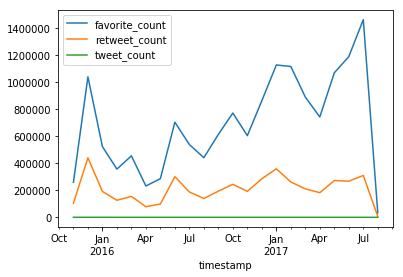

In [97]:
tweet_counts_by_month.plot()

'tweet_count' looks flat on this scale, so it may need to be pulled out and looked at individually.

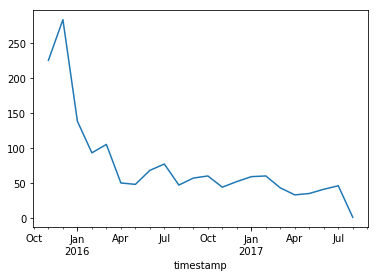

In [98]:
# plot 'tweet_count' individually
tweet_counts_by_month.tweet_count.plot()

The tweet count was more per month at the beginning of the archive and then levelled off. More tweets in the beginning may explain the bump at the beginning with higher favorites and retweets. As time went on, it seems that the popularity grew, so there were more retweets and favorites.

After looking at 'tweet_count', the other variables should be pulled out to see if scaling by themselves will make the variable plots look different.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a7b73c8>,
      dtype=object)

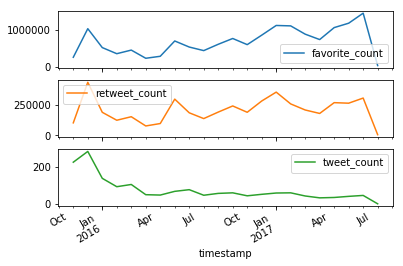

In [99]:
tweet_counts_by_month.plot(subplots=True)

Sure enough, when the scale is changed, the variations in the curves more or less match.

To get a better gauge of popularity, looking at the retweets and favorites per tweet may help account for the peak at the beginning of the archive.

In [100]:
per_tweet_archive_by_month = tweet_counts_by_month.copy()
per_tweet_archive_by_month['favorite_count'] /= per_tweet_archive_by_month['tweet_count']
per_tweet_archive_by_month['retweet_count'] /= per_tweet_archive_by_month['tweet_count']
per_tweet_archive_by_month.drop('tweet_count', axis=1, inplace=True)
per_tweet_archive_by_month.columns = ['favorite_count_per_tweet', 'retweet_count_per_tweet']

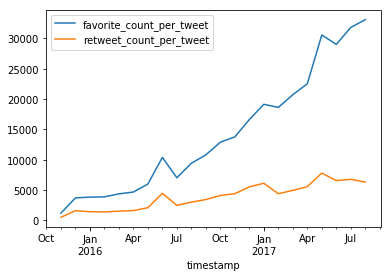

In [101]:
per_tweet_archive_by_month.plot()

The 'per_tweet' plot paints a clearer picture of growing popularity.

<a id='tweet_counts_by_hour'></a>
#### Tweet counts by hour of day

In [102]:
tweet_counts_by_hour = tweet_archive_master[['timestamp', 'favorite_count', 'retweet_count']]
tweet_counts_by_hour.timestamp = tweet_counts_by_hour.timestamp.map(lambda x: x.hour)

/Users/charlesdellinger/anaconda2/envs/Python3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


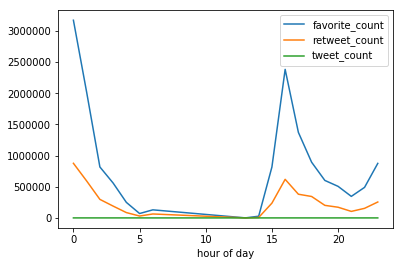

In [103]:
tweet_counts_by_hour = pd.concat([tweet_counts_by_hour.groupby('timestamp').sum(), 
                                  tweet_counts_by_hour.groupby('timestamp').count()['favorite_count'].rename('tweet_count')],
                                 axis = 1)
tweet_counts_by_hour.index.names = ['hour of day']
tweet_counts_by_hour.plot()

There seems to be sharp peaks in the 'favorite_count' and 'retweet_count', but because of the scale, the 'tweet_count' looks flat again, so it need to be pulled out.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b199e80>,
      dtype=object)

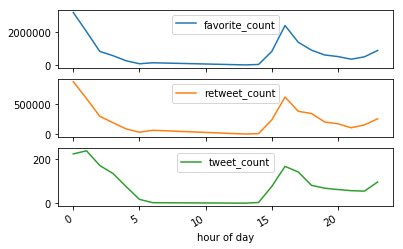

In [104]:
tweet_counts_by_hour.plot(subplots=True)

When pulled out and scaled, all the variations more or less match, but at different scales.

As a whole, there seems to be not too many tweets during business hours. The amount of tweets sharply peaks near the close of business and then trails off towards individuals' bedtimes. Suprisingly, there is another peak in the middle of the night.

<a id='dog_ratings_over_time'></a>
#### Dog ratings over time

In [105]:
ave_ratings_over_time = tweet_archive_master[['timestamp', 'rating_numerator']].groupby(pd.Grouper(key='timestamp', freq='M')).mean()
# strip date to month like before
ave_ratings_over_time.index = tweet_archive_by_month.index.map(strip_date)

NameError: name 'tweet_archive_by_month' is not defined

In [ ]:
ave_ratings_over_time.plot()

It isn't a huge increase, but as time went on, the average dog rating increased. The increase in rating may be because the tweet account started to develop its character to keep pace with follower expectations as the following grew.

In [ ]:
pd.concat([per_tweet_archive_by_month, ave_ratings_over_time], axis=1).plot(subplots=True)

Looking at the trends, the increase in 'rating_numerator' kept pace with the increase of the 'per_tweet' variables but on a lesser scale.

<a id='dog_breed_ratings'></a>
#### Average dog breed popularity

There may be too many breeds to have a reasonable analysis of the breeds.

In [ ]:
print('number of breeds: {}'.format(len(tweet_archive_master['dog_breed'].value_counts())))

There are definitely too many breeds to look at all at once, so the top 20 based on number of tweets will be chosen to look at since they have each have a larger sample size.

In [ ]:
top_20_breeds = tweet_archive_master['dog_breed'].value_counts().index[:20]

In [ ]:
top_20_breed_archive = tweet_archive_master[tweet_archive_master.dog_breed.isin(top_20_breeds)]

In [ ]:
top_20_breed_stats = top_20_breed_archive.groupby('dog_breed').mean()

From the analysis over time, the 'rating_numerator' shouldn't have too much variation, so that column needs to be pulled out by itself.

In [ ]:
top_20_breed_stats['rating_numerator'].sort_values(ascending=False).plot(kind='bar', ylim=[10,12])

There isn't a lot of difference overall, but the average rating starts dropping more sharply after rank 16.

The average 'favorite_count' and 'retweet_count' by breed would be the only other interesting things.

In [ ]:
top_20_breed_stats[['favorite_count','retweet_count']].sort_values(by='favorite_count', ascending=False).plot(kind='bar', subplots=True)

Nothing stands out except that 'French_bulldog' is a clear winner.

In [ ]:
top_20_breed_stats['favorite_count'].sort_values(ascending=False).plot(kind='bar', subplots=True)

Pulling 'favorite_count' out shows that there is a huge jump even between 'French_bulldog' and the next highest average favorite count. 'French_bulldog' is definitely the most liked dog based on average favorite count.

<a id='dog_stage_ratings'></a>
#### Dog stage ratings

In [ ]:
dog_stage_stats = tweet_archive_master[['dog_stage', 'rating_numerator', 'favorite_count', 'retweet_count']].groupby('dog_stage').mean()


In [ ]:
dog_stage_stats['rating_numerator'].sort_values(ascending=False).plot(kind='bar', ylim=[10,13])

In [ ]:
dog_stage_stats[['favorite_count', 'retweet_count']].sort_values(by='favorite_count', ascending=False).plot(kind='bar', subplots=True)

Based on retweets and favorite counts, people tend to like puppos and doggos the most.